# Putting the pieces of kicker data together 
#### Matthew Johnson, August 13, 2018

$KickerPts = 1 *(Made PAT) + 3*(FG_{d\leq 39}) + 4*(FG_{d\in [40,49]}) + 5*(FG_{d\geq 50}) - 1*(Missed FG)$
<br>

- Calculate predictions for data, data + vegas, data + weather, all 3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, make_pipeline
warnings.filterwarnings('ignore')

kickers09to17 = pd.read_csv('kicker_data_09_17_good.csv')
weather09to13 = pd.read_csv('weather_data09to13.csv') 
vegas09to17 = pd.read_csv('vegas_odds09to17.csv') # Weeks 6-16

dfs = [kickers09to17, weather09to13, vegas09to17]
dfs[1].drop('Unnamed: 0', axis=1, inplace=True)
dfs[2].drop('Unnamed: 0', axis=1, inplace=True)

In [2]:
mergecodes = []
mergecodes2 = []

for df in dfs:
    print (df.shape)
    mergecodes.append(list(df['mergeCode'].unique()))
    mergecodes2.append(list(df['mergeCode2'].unique()))

(2826, 65)
(2058, 16)
(2878, 10)


In [3]:
# deciding whether to merge on mergeCode
A = set(mergecodes[0]) # A - kicker data
B = set(mergecodes[1]) # B - weather
C = set(mergecodes[2]) # C - vegas odds

intersect1 = A.intersection(B)
intersect_all = intersect1.intersection(C)
print('kicker+weather:', len(intersect1))
print('int_all:', len(intersect_all))

kicker+weather: 1197
int_all: 1126


In [4]:
# deciding whether to merge on mergeCode2
A = set(mergecodes2[0]) # A - kicker data
B = set(mergecodes2[1]) # B - weather
C = set(mergecodes2[2]) # C - vegas odds

intersect1 = A.intersection(B)
intersect_all = intersect1.intersection(C)
print('kicker+weather:', len(intersect1))
print('int_all:', len(intersect_all))

kicker+weather: 1257
int_all: 1157


In [5]:
# mergeCode2 it is:
df1 = pd.merge(dfs[0], dfs[1], on='mergeCode2', how='inner')
df2 = pd.merge(df1, dfs[2], on='mergeCode2', how='inner')
print(df2.shape)

(1175, 89)


In [6]:
offenseVariables = ['3rdDown_rate', 'Drive', 'FirstDown','Kicker_Pts',
    'TwoPointConv','Drive_rolling5', 'Kicker_Pts_rolling5', 
    'PointsScored_rolling5', 'Yards.Gained_rolling5', 'FG_range_per_drive', 'RZ_per_drive',
    'punts_per_drive', 'Completion_pct', 'TwoPoint_conv_rate']

defenseVariables = ['DEF_3rdDownSuccess_rolling5', 'DEF_Drive_rolling5', 'DEF_FirstDown_rolling5', 
    'DEF_Kicker_Pts_rolling5',  'DEF_Touchdown_rolling5', 
    'DEF_Yards.Gained_rolling5','DEF_FG_range_per_drive', 'DEF_RZ_per_drive', 'DEF_PointsScored_rolling5',
    'DEF_punts_per_drive', 'DEF_Completion_pct']

generalVariables = ['offenseTeam.1', 'defenseTeam_x', 'Season_x', 'Week_y', 'date_x', 
        'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity', 'wind_mph', 
        'home_team', 'Year', 
        'Relative_Line', 'Total', 'Exp_Pts', 'mergeCode', 'mergeCode2', 'mergeCode_x']

df_off = df2[offenseVariables]
df_def = df2[defenseVariables]
df_gen = df2[generalVariables]

df_gen.columns = ['offenseTeam', 'defenseTeam', 'Season', 'Week', 'date',
       'off_score', 'def_score', 'temperature', 'wind_chill', 'humidity',
       'wind_mph', 'home_team', 'Year', 'Relative_Line', 'Total', 'Exp_Pts', 
       'mergeCode', 'mergeCode2', 'mergeCode_x']

data = pd.concat([df_gen, df_off, df_def], axis=1)
kicker_pts = df2['Kicker_Pts']

In [7]:
# outliers, not currently being used
outliers = data[ (data['Kicker_Pts'] <= 1) | (data['Kicker_Pts'] >= 25)]
outliers.shape
#data_drop_outliers = data[ (data['Kicker_Pts'] >= 1) | (data['Kicker_Pts'] <= 25)]

(62, 44)

**We remove the 'off_score' and 'def_score' due to those being unknown quantities pre game, leaving these in would cause data leakage.**

In [8]:
data2 = data.drop(['off_score', 'def_score'], axis=1)
data2['Season'] = data2['Season'].astype('category')
data2['Week'] = data2['Week'].astype('category')
data2['Year'] = data2['Year'].astype('category')

num_data = data2.select_dtypes(include=['int64', 'float64'])

**Visualizing Kicker_Pts distribution:**

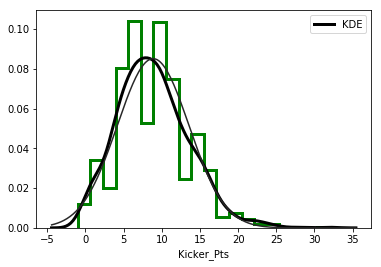

In [9]:
from scipy.stats import norm

sns.distplot(kicker_pts, bins=20, fit=norm,
            kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"});

### Correlations:

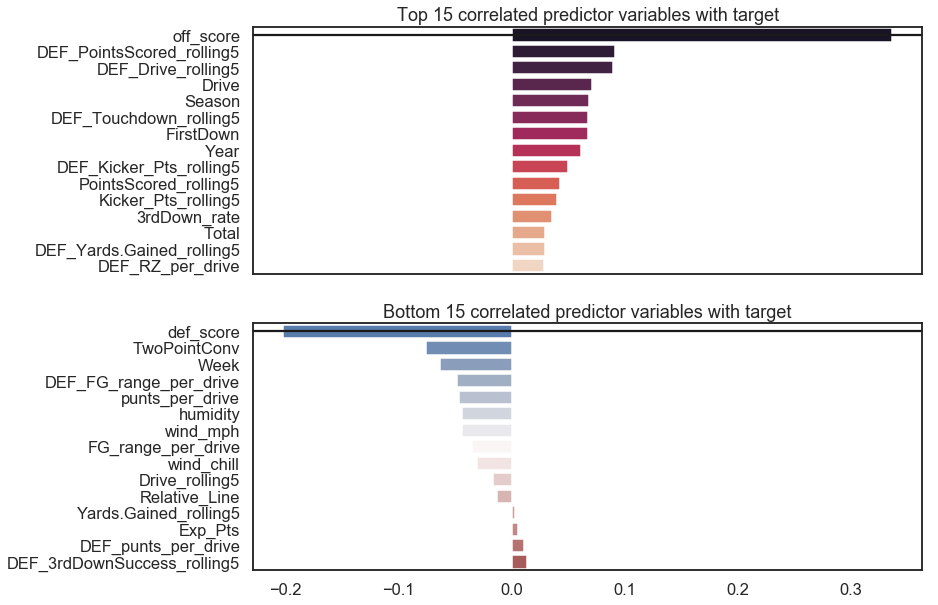

In [11]:
sns.set(style="white", context="talk")

corr_rank = data.corr()['Kicker_Pts'].sort_values(ascending=False)

corr_rank_high = corr_rank[1:16]
corr_rank_low = corr_rank[-18:-3].sort_values(ascending=True)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.barplot(y=corr_rank_high.index, x=corr_rank_high.values, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_title('Top 15 correlated predictor variables with target')

sns.barplot(y=corr_rank_low.index, x=corr_rank_low.values, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_title('Bottom 15 correlated predictor variables with target');

### Modelling

In [12]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [13]:
rolling_kpts = num_data['Kicker_Pts_rolling5'].copy()
rolling_kpts.columns = ['Kicker_Pts_rolling5b']
def_rolling_kpts = num_data['DEF_Kicker_Pts_rolling5'].copy()
def_rolling_kpts.columns = ['DEF_Kicker_Pts_rolling5b']

In [14]:
from scipy.stats import norm, skew

all_data = num_data.drop(['Kicker_Pts', 'Relative_Line', 'TwoPoint_conv_rate'], axis=1)

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
TwoPointConv,5.576
3rdDown_rate,4.106
DEF_3rdDownSuccess_rolling5,3.326
wind_mph,1.350
DEF_FirstDown_rolling5,0.347


In [15]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
#skewed_features = skewed_features.drop(['Relative_Line', 'TwoPoint_conv_rate'])
print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data = pd.concat([all_data, num_data['Relative_Line']], axis=1)

There are 29 skewed numerical features to Box Cox transform


In [16]:
all_data['3rdDown_rate'].fillna(all_data['3rdDown_rate'].mean(), inplace=True)
all_data['wind_chill'].fillna(all_data['temperature'], inplace=True)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = pd.concat([all_data, rolling_kpts, num_data['Relative_Line']], axis=1)
y = kicker_pts

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 2018)
rf2.fit(Xtrain, ytrain);

In [21]:
predictions = rf2.predict(Xtest)
errors = abs(predictions - ytest)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 3.91


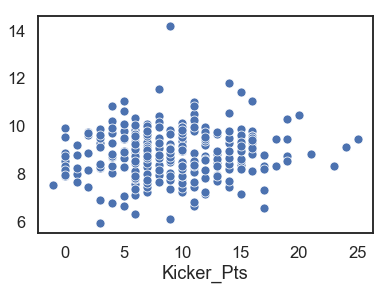

In [22]:
sns.scatterplot(x=ytest, y=predictions);

In [23]:
rf_df = pd.DataFrame({'feature': pd.Series(X.columns),'importance': rf2.feature_importances_})
rf_df.sort_values(by='importance', ascending=False)[0:10]

,feature,importance
23,DEF_Yards.Gained_rolling5,0.060
13,Yards.Gained_rolling5,0.060
27,DEF_punts_per_drive,0.050
0,temperature,0.047
14,FG_range_per_drive,0.046
25,DEF_RZ_per_drive,0.045
15,RZ_per_drive,0.045
8,FirstDown,0.045
2,humidity,0.044
12,PointsScored_rolling5,0.042


In [25]:
pred_df = pd.DataFrame({'Actual': ytest, 'Pred': predictions, 'Rolling':Xtest['Kicker_Pts_rolling5'].iloc[:,1]})

pred_df['residual'] = abs(pred_df['Actual'] - pred_df['Pred'])
pred_df['roll_res'] = abs(pred_df['Actual'] - pred_df['Rolling'])

In [26]:
pred_df.describe()

,Actual,Pred,Rolling,residual,roll_res
count,294.000,294.000,294.000,294.000,294.000
mean,9.296,8.844,8.704,3.905,4.286
std,4.809,1.016,2.185,2.858,3.231
min,-1.000,5.922,2.000,0.023,0.000
25%,6.000,8.182,7.000,1.746,2.000
50%,9.000,8.858,9.000,3.364,4.000
75%,12.000,9.490,10.000,5.698,6.000
max,25.000,14.189,15.000,15.545,17.000


In [29]:
good_guess = pred_df[ pred_df['residual'] <= 2.0 ]
poor_guess = pred_df[ pred_df['residual'] >= 7.0 ]
poor_guess.sort_values(by='residual', ascending=False).head()

,Actual,Pred,Rolling,residual,roll_res
742,25,9.455,8,15.545,17
570,24,9.117,9,14.883,15
323,23,8.319,8,14.681,15
704,21,8.817,11,12.183,10
497,19,8.528,9,10.472,10


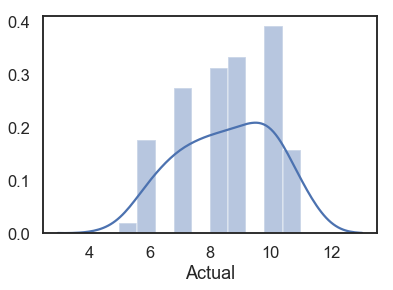

In [31]:
sns.distplot(good_guess['Actual'], bins=10)

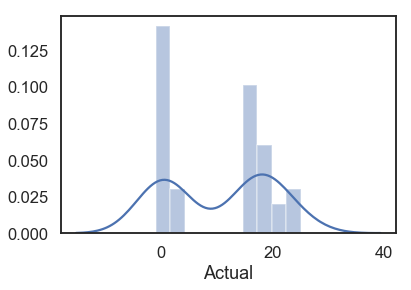

In [33]:
sns.distplot(poor_guess['Actual'], bins=10)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [40]:
rfr=RandomForestRegressor(random_state=2018)

param_grid = { 
    'n_estimators': [1000, 2000, 3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

In [41]:
CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
CV_rfc.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2018, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1000, 2000, 3000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [42]:
rfr_pred = CV_rfc.predict(Xtest)

In [43]:
abs(ytest-rfr_pred).mean()

3.8931239762609